In [1]:
!python -m pip install torch
!python -m pip install torchvision
!python -m pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)").html
!python -m pip install torch-geometric networkx matplotlib
!python -m pip install pandas numpy

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'import torch; print(torch.__version__)).html'


  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)


In [20]:
# check pytorch version
import torch
print(torch.__version__)

2.4.1+cu121


In [27]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.nn import GCN
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import accuracy_score
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx

In [12]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

In [23]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    # Optional: print training progress
    if epoch % 20 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}')

Epoch 000, Loss: 1.9546
Epoch 020, Loss: 0.2153
Epoch 040, Loss: 0.0566
Epoch 060, Loss: 0.0471
Epoch 080, Loss: 0.0457
Epoch 100, Loss: 0.0344
Epoch 120, Loss: 0.0450
Epoch 140, Loss: 0.0388
Epoch 160, Loss: 0.0475
Epoch 180, Loss: 0.0335


In [25]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8120


In [26]:
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)

In [115]:
pred.cpu().numpy()

array([3, 4, 4, ..., 0, 3, 3], dtype=int64)

In [28]:
G = to_networkx(data, to_undirected=True)

In [29]:
pos = nx.spring_layout(G)

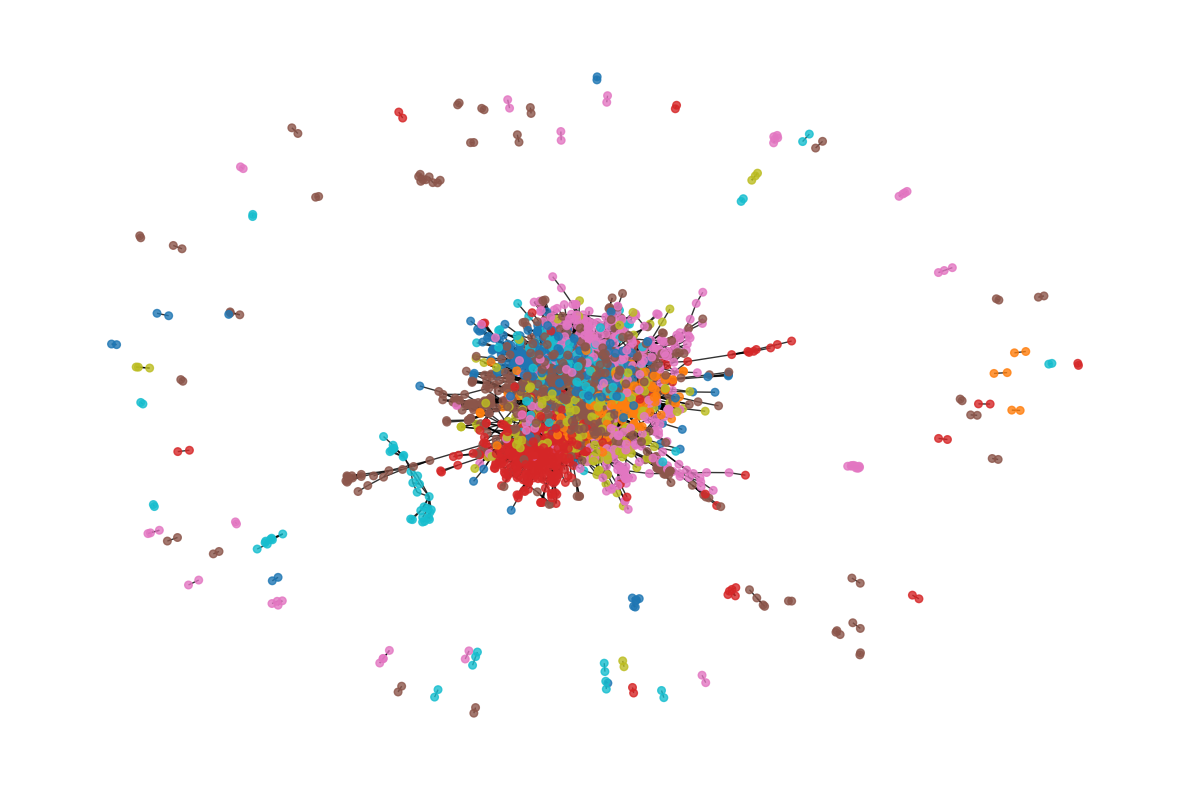

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))

nx.draw(G, pos, node_size=30, node_color=pred.cpu().numpy(), cmap=plt.cm.tab10, 
        with_labels=False, alpha=0.8, ax=ax)

plt.tight_layout()
plt.show()

In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

def train_and_evaluate(dataset_name):
    dataset = TUDataset(root=f'/tmp/{dataset_name}', name=dataset_name)
    
    # Split the dataset
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN(dataset.num_node_features, dataset.num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    model.train()
    for epoch in range(100):
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
        total += data.num_graphs

    accuracy = correct / total
    print(f'{dataset_name} Accuracy: {accuracy:.4f}')
    return accuracy

#imdb_accuracy = train_and_evaluate('IMDB-BINARY')
enzymes_accuracy = train_and_evaluate('ENZYMES')

ENZYMES Accuracy: 0.2917


In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

def create_one_hot_features(data):
    num_nodes = data.num_nodes
    one_hot_features = torch.zeros((num_nodes, num_nodes), dtype=torch.float)

    # Create one-hot encoding based on edges
    for i in range(data.edge_index.size(1)):
        source, target = data.edge_index[:, i]
        one_hot_features[source, target] = 1

    # Instead of using a full one-hot representation, reduce to simple feature count
    # Here we will create a binary feature indicating if a node is connected to any other node
    num_features = 1  # We will use a single feature indicating connectivity
    feature_vector = one_hot_features.sum(dim=1).view(-1, num_features)  # Summing connections

    return feature_vector

def train_and_evaluate(dataset_name):
    dataset = TUDataset(root=f'/tmp/{dataset_name}', name=dataset_name)

    # Split the dataset
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN(dataset.num_node_features or 1, dataset.num_classes).to(device)  # Use 1 if no features

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    model.train()
    for epoch in range(8):
        epoch_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()

            # Check if there are node features; if not, create one-hot features
            if data.x is None:
                data.x = create_one_hot_features(data).to(device)  # One-hot features based on connections

            out = model(data.x, data.edge_index, data.batch)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')

    # Evaluation loop
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)

        # Check if there are node features; if not, create one-hot features
        if data.x is None:
            data.x = create_one_hot_features(data).to(device)

        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
        total += data.num_graphs

        all_preds.append(pred.cpu())
        all_labels.append(data.y.cpu())

    accuracy = correct / total
    print(f'{dataset_name} Accuracy: {accuracy:.4f}')

    # Flatten predictions and labels for printing
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Print predictions vs actual labels
    print("Predictions vs Actual:")
    for pred, label in zip(all_preds, all_labels):
        print(f'Predicted: {pred.item()}, Actual: {label.item()}')

    return accuracy

train_and_evaluate('IMDB-BINARY')


Epoch 1, Loss: 17.6353
Epoch 2, Loss: 17.4836
Epoch 3, Loss: 17.2989
Epoch 4, Loss: 17.3683
Epoch 5, Loss: 17.3315
Epoch 6, Loss: 17.3337
Epoch 7, Loss: 17.3345
Epoch 8, Loss: 17.2987
IMDB-BINARY Accuracy: 0.5050
Predictions vs Actual:
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 0
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 1
Predicted: 1, Actual: 0
Predicted: 1, Actual

0.505

In [17]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

def create_degree_features(data):
    # Calculate node degrees
    num_nodes = data.num_nodes
    degrees = torch.bincount(data.edge_index[0], minlength=num_nodes)
    
    # Convert degrees to a feature matrix (num_nodes x 1)
    feature_vector = degrees.view(-1, 1).float()
    
    return feature_vector

def train_and_evaluate(dataset_name):
    dataset = TUDataset(root=f'/tmp/{dataset_name}', name=dataset_name)

    # Split the dataset
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN(dataset.num_node_features or 1, dataset.num_classes).to(device)  # Use 1 if no features

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training loop
    model.train()
    for epoch in range(200):
        epoch_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()

            # Check if there are node features; if not, use node degrees as features
            if data.x is None:
                data.x = create_degree_features(data).to(device)  # Node degree features

            out = model(data.x, data.edge_index, data.batch)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')

    # Evaluation loop
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)

        # Check if there are node features; if not, use node degrees as features
        if data.x is None:
            data.x = create_degree_features(data).to(device)

        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
        total += data.num_graphs

        all_preds.append(pred.cpu())
        all_labels.append(data.y.cpu())

    accuracy = correct / total
    print(f'{dataset_name} Accuracy: {accuracy:.4f}')
    
    return accuracy

train_and_evaluate('IMDB-BINARY')

Epoch 1, Loss: 18.2404
Epoch 2, Loss: 17.9565
Epoch 3, Loss: 17.3395
Epoch 4, Loss: 17.3298
Epoch 5, Loss: 17.4553
Epoch 6, Loss: 17.3349
Epoch 7, Loss: 17.3816
Epoch 8, Loss: 17.3714
Epoch 9, Loss: 17.3123
Epoch 10, Loss: 17.2200
Epoch 11, Loss: 17.0187
Epoch 12, Loss: 16.7755
Epoch 13, Loss: 16.2103
Epoch 14, Loss: 15.9750
Epoch 15, Loss: 15.5653
Epoch 16, Loss: 15.5360
Epoch 17, Loss: 16.2606
Epoch 18, Loss: 15.5591
Epoch 19, Loss: 15.2570
Epoch 20, Loss: 15.3614
Epoch 21, Loss: 15.1237
Epoch 22, Loss: 14.9432
Epoch 23, Loss: 15.6898
Epoch 24, Loss: 15.2117
Epoch 25, Loss: 15.1024
Epoch 26, Loss: 14.8121
Epoch 27, Loss: 15.0753
Epoch 28, Loss: 14.8300
Epoch 29, Loss: 14.9190
Epoch 30, Loss: 15.4501
Epoch 31, Loss: 15.4563
Epoch 32, Loss: 15.0333
Epoch 33, Loss: 14.9109
Epoch 34, Loss: 14.7941
Epoch 35, Loss: 15.1019
Epoch 36, Loss: 15.0466
Epoch 37, Loss: 15.1817
Epoch 38, Loss: 14.9987
Epoch 39, Loss: 14.8125
Epoch 40, Loss: 14.8559
Epoch 41, Loss: 14.7725
Epoch 42, Loss: 14.7660
E

0.735

In [105]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.fc = torch.nn.Linear(16, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

def train_and_evaluate(dataset_name):
    dataset = TUDataset(root=f'/tmp/{dataset_name}', name=dataset_name)

    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    num_node_features = dataset.num_node_features or 1
    model = GCN(num_node_features, dataset.num_classes).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    model.train()
    for epoch in range(15):
        epoch_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()

            if data.x is None:
                data.x = torch.ones((data.num_nodes, 1), device=device) 

            out = model(data.x, data.edge_index, data.batch)
            loss = F.nll_loss(out, data.y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')

    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)

        if data.x is None:
            data.x = torch.ones((data.num_nodes, 1), device=device)

        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
        total += data.num_graphs

        all_preds.append(pred.cpu())
        all_labels.append(data.y.cpu())

    accuracy = correct / total
    print(f'{dataset_name} Accuracy: {accuracy:.4f}')

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    print("Predictions vs Actual:")
    for pred, label in zip(all_preds, all_labels):
        print(f'Predicted: {pred.item()}, Actual: {label.item()}')

    return accuracy

train_and_evaluate('IMDB-BINARY')

Epoch 1, Loss: 17.4821
Epoch 2, Loss: 17.3434
Epoch 3, Loss: 17.3409
Epoch 4, Loss: 17.3410
Epoch 5, Loss: 17.3375
Epoch 6, Loss: 17.3385
Epoch 7, Loss: 17.3646
Epoch 8, Loss: 17.3503
Epoch 9, Loss: 17.3312
Epoch 10, Loss: 17.3320
Epoch 11, Loss: 17.3477
Epoch 12, Loss: 17.3335
Epoch 13, Loss: 17.3415
Epoch 14, Loss: 17.3342
Epoch 15, Loss: 17.3283
IMDB-BINARY Accuracy: 0.4800
Predictions vs Actual:
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual:

0.48